In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
!nvidia-smi

Fri Mar  7 01:35:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.15              Driver Version: 570.86.15      CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          On  |   00000000:17:00.0 Off |                    0 |
| N/A   34C    P0             52W /  300W |       1MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor, AutoModel 
from qwen_vl_utils import process_vision_info

import glob
import time
import json
from IPython.display import display            

import torch
import json
import random
import io
import ast
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageColor
import os
import sys


#import Levenshtein
from shapely.validation import explain_validity
from shapely.geometry import Polygon
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from collections import Counter

import tools.infer.utility as utility
from ppocr.utils.logging import get_logger
from ppocr.utils.utility import get_image_file_list, check_and_read
from ppocr.data import create_operators, transform
from ppocr.postprocess import build_post_process

/gpfs/projects/CascanteBonillaGroup/jmurrugarral/anaconda3/envs/py10-qocr-flash/lib/python3.10/site-packages/transformers/utils/hub.py:106: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
which: no ccache in (/cm/shared/apps/slurm/current/sbin:/cm/shared/apps/slurm/current/bin:/gpfs/projects/CascanteBonillaGroup/jmurrugarral/anaconda3/envs/py10-qocr-flash/bin:/gpfs/projects/CascanteBonillaGroup/jmurrugarral/anaconda3/condabin:/cm/local/apps/environment-modules/4.5.3/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/cm/local/apps/environment-modules/current/bin:/gpfs/software/local/bin:/gpfs/home/jmurrugarral/bin)
/gpfs/projects/CascanteBonillaGroup/jmurrugarral/anaconda3/envs/py10-qocr-flash/lib/python3.10/site-packages/paddle/utils/cpp_extension/extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and insta

In [4]:
# __dir__ = os.path.dirname(os.path.abspath(__file__))
__dir__ = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(__dir__)
sys.path.insert(0, os.path.abspath(os.path.join(__dir__, "../..")))
#sys.path.insert(0, os.path.abspath(os.path.join(__dir__, "PaddleOCR")))


os.environ["FLAGS_allocator_strategy"] = "auto_growth"
logger = get_logger()


class TextE2E(object):
    def __init__(self, args):
        self.args = args
        self.e2e_algorithm = args.e2e_algorithm
        self.use_onnx = args.use_onnx
        pre_process_list = [
            {"E2EResizeForTest": {}},
            {
                "NormalizeImage": {
                    "std": [0.229, 0.224, 0.225],
                    "mean": [0.485, 0.456, 0.406],
                    "scale": "1./255.",
                    "order": "hwc",
                }
            },
            {"ToCHWImage": None},
            {"KeepKeys": {"keep_keys": ["image", "shape"]}},
        ]
        postprocess_params = {}
        if self.e2e_algorithm == "PGNet":
            pre_process_list[0] = {
                "E2EResizeForTest": {
                    "max_side_len": args.e2e_limit_side_len,
                    "valid_set": "totaltext",
                }
            }
            postprocess_params["name"] = "PGPostProcess"
            postprocess_params["score_thresh"] = args.e2e_pgnet_score_thresh
            postprocess_params["character_dict_path"] = args.e2e_char_dict_path
            postprocess_params["valid_set"] = args.e2e_pgnet_valid_set
            postprocess_params["mode"] = args.e2e_pgnet_mode
        else:
            logger.info("unknown e2e_algorithm:{}".format(self.e2e_algorithm))
            sys.exit(0)

        self.preprocess_op = create_operators(pre_process_list)
        self.postprocess_op = build_post_process(postprocess_params)
        (
            self.predictor,
            self.input_tensor,
            self.output_tensors,
            _,
        ) = utility.create_predictor(
            args, "e2e", logger
        )  # paddle.jit.load(args.det_model_dir)
        # self.predictor.eval()

    def clip_det_res(self, points, img_height, img_width):
        for pno in range(points.shape[0]):
            points[pno, 0] = int(min(max(points[pno, 0], 0), img_width - 1))
            points[pno, 1] = int(min(max(points[pno, 1], 0), img_height - 1))
        return points

    def filter_tag_det_res_only_clip(self, dt_boxes, image_shape):
        img_height, img_width = image_shape[0:2]
        dt_boxes_new = []
        for box in dt_boxes:
            box = self.clip_det_res(box, img_height, img_width)
            dt_boxes_new.append(box)
        dt_boxes = np.array(dt_boxes_new)
        return dt_boxes

    def __call__(self, img):
        ori_im = img.copy()
        data = {"image": img}
        data = transform(data, self.preprocess_op)
        img, shape_list = data
        if img is None:
            return None, 0
        img = np.expand_dims(img, axis=0)
        shape_list = np.expand_dims(shape_list, axis=0)
        img = img.copy()
        starttime = time.time()

        if self.use_onnx:
            input_dict = {}
            input_dict[self.input_tensor.name] = img
            outputs = self.predictor.run(self.output_tensors, input_dict)
            preds = {}
            preds["f_border"] = outputs[0]
            preds["f_char"] = outputs[1]
            preds["f_direction"] = outputs[2]
            preds["f_score"] = outputs[3]
        else:
            self.input_tensor.copy_from_cpu(img)
            self.predictor.run()
            outputs = []
            for output_tensor in self.output_tensors:
                output = output_tensor.copy_to_cpu()
                outputs.append(output)

            preds = {}
            if self.e2e_algorithm == "PGNet":
                preds["f_border"] = outputs[0]
                preds["f_char"] = outputs[1]
                preds["f_direction"] = outputs[2]
                preds["f_score"] = outputs[3]
            else:
                raise NotImplementedError
        post_result = self.postprocess_op(preds, shape_list)
        #print(post_result)
        points, strs = post_result["points"], post_result["texts"]
        dt_boxes = self.filter_tag_det_res_only_clip(points, ori_im.shape)
        elapse = time.time() - starttime
        return dt_boxes, strs, elapse


args = utility.parse_args()
args.e2e_algorithm="PGNet"
args.image_dir='../cropped_image.jpg'
args.e2e_model_dir="./inference/e2e_server_pgnetA_infer/"
args.use_gpu=False
args.e2e_pgnet_valid_set="totaltext"

text_detector = TextE2E(args)

draw_img_save = "./inference_results"
if not os.path.exists(draw_img_save):
    os.makedirs(draw_img_save)


In [5]:
sam_checkpoint = "../sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [6]:

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct", 
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    device_map="auto"
)

processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct")
model.eval()

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Qwen2_5_VLForConditionalGeneration(
  (visual): Qwen2_5_VisionTransformerPretrainedModel(
    (patch_embed): Qwen2_5_VisionPatchEmbed(
      (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
    )
    (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
    (blocks): ModuleList(
      (0-31): 32 x Qwen2_5_VLVisionBlock(
        (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
        (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
        (attn): Qwen2_5_VLVisionFlashAttention2(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (mlp): Qwen2_5_VLMLP(
          (gate_proj): Linear(in_features=1280, out_features=3420, bias=True)
          (up_proj): Linear(in_features=1280, out_features=3420, bias=True)
          (down_proj): Linear(in_features=3420, out_features=1280, bias=True)
          (act_fn): SiLU()
        )
      )
    )
    (merger): Qwen2_5_VLPatchMerg

In [14]:

import io
import pandas as pd
import numpy as np

def flatten_list_remove_na(data_list):
  flat_list = []
  for sublist in data_list:
    for item in sublist:
      if item.lower() != 'na':
        flat_list.append(item)
  return flat_list

df = pd.read_csv(io.StringIO('''
"bank account,financial statement",na
mail,address
"credit card,debit card",na
"billing statement,customer receipt",na
na,"medical information,patient medical record"
na,na
"loan,financial statement",credit history
prescription,na
na,na
na,na
biometric,na
transcript,education level
employment,"id card, driver license"
na,"medical information,patient medical record"
na,na
"medical information,patient medical record",na
biometric,na
na,na
phone number,na
'''), header=None)

data_list = df.values.tolist()
print(data_list)
flattened_data = flatten_list_remove_na(data_list)
all_categories = flattened_data
unique_categories = list(set(all_categories))

def process_string(input_string):
  if ',' in input_string:
    parts = input_string.split(',')
    cleaned_parts = [part.strip() for part in parts if part.strip()]
  else:
    cleaned_parts = [input_string]

  return cleaned_parts

processed_strs = []
for s in unique_categories:
  processed_strs.extend(process_string(s))
unique_categories = []
unique_categories = processed_strs
unique_categories.append("credit card number")
unique_categories.append("personal name")
unique_categories.append("company name")
unique_categories.append("unsure")
unique_categories.append("other")


[['bank account,financial statement', 'na'], ['mail', 'address'], ['credit card,debit card', 'na'], ['billing statement,customer receipt', 'na'], ['na', 'medical information,patient medical record'], ['na', 'na'], ['loan,financial statement', 'credit history'], ['prescription', 'na'], ['na', 'na'], ['na', 'na'], ['biometric', 'na'], ['transcript', 'education level'], ['employment', 'id card, driver license'], ['na', 'medical information,patient medical record'], ['na', 'na'], ['medical information,patient medical record', 'na'], ['biometric', 'na'], ['na', 'na'], ['phone number', 'na']]


In [8]:
print(unique_categories)

['credit card', 'debit card', 'loan', 'financial statement', 'education level', 'address', 'biometric', 'phone number', 'billing statement', 'customer receipt', 'id card', 'driver license', 'credit history', 'mail', 'bank account', 'financial statement', 'employment', 'prescription', 'transcript', 'medical information', 'patient medical record', 'credit card number', 'personal name', 'company name', 'unsure', 'other']


In [18]:
additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

def pil_to_opencv(img):
    return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

def opencv_to_pil(img):
    return Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
def plot_bounding_boxes(im, bounding_boxes, input_width, input_height, image_width, image_height, json=False):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        bounding_boxes: A list of bounding boxes containing the name of the object
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = ['red','green','blue','yellow','orange','pink','purple','brown','gray','beige','turquoise','cyan','magenta','lime','navy','maroon',
    'teal','olive','coral','lavender','violet','gold','silver',] + additional_colors

    if json == False:

        # Parsing out the markdown fencing
        bounding_boxes = parse_json(bounding_boxes)

        #font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=14)

        try:
          json_output = ast.literal_eval(bounding_boxes)
        except Exception as e:
          end_idx = bounding_boxes.rfind('"}') + len('"}')
          truncated_text = bounding_boxes[:end_idx] + "]"
          json_output = ast.literal_eval(truncated_text)
    else:
        #json_output = ast.literal_eval(bounding_boxes)
        json_output = bounding_boxes

    bboxes = np.zeros((int(len(json_output)),4))
    labels = []

    # Iterate over the bounding boxes
    for i, bounding_box in enumerate(json_output):
      # Select a color from the list
      color = colors[i % len(colors)]

      bboxes[i,:] = np.array([int(bounding_box["bbox_2d"][0]/input_width * image_width),
                              int(bounding_box["bbox_2d"][1]/input_height * image_height),
                              int(bounding_box["bbox_2d"][2]/input_width * image_width),
                              int(bounding_box["bbox_2d"][3]/input_height * image_height)])



      # Convert normalized coordinates to absolute coordinates
      abs_y1 = int(bounding_box["bbox_2d"][1]/input_height * height)
      abs_x1 = int(bounding_box["bbox_2d"][0]/input_width * width)
      abs_y2 = int(bounding_box["bbox_2d"][3]/input_height * height)
      abs_x2 = int(bounding_box["bbox_2d"][2]/input_width * width)

      if abs_x1 > abs_x2:
        abs_x1, abs_x2 = abs_x2, abs_x1
        bboxes[i,0], bboxes[i,2] = bboxes[i,2], bboxes[i,0]


      if abs_y1 > abs_y2:
        abs_y1, abs_y2 = abs_y2, abs_y1
        bboxes[i,1], bboxes[i,3] = bboxes[i,3], bboxes[i,1]

      #bboxes[i,:] = np.array([abs_x1, abs_y1, abs_x2, abs_y2])

      # Draw the bounding box
      draw.rectangle(((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4)

      # Draw the text
      if "label" in bounding_box:
        draw.text((abs_x1 + 8, abs_y1 + 6), bounding_box["label"], fill=color)#, font=font)

      if "text_content" in bounding_box:
        labels.append(bounding_box["text_content"])

    # Display the image
    #img.show()

    return img, bboxes, labels

# @title Parsing JSON output
def parse_json(json_output):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i+1:])  # Remove everything before "```json"
            json_output = json_output.split("```")[0]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output

def locate_private_content(img_full_path, prompt, temperature = 1, top_p = 0.8, grounding = True, max_token = 128):

    max_new_tokens = max_token
    messages = [
        {
            "role": "system",
            "content": "You are a helpful assistant"
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": prompt
                },
                {
                  "image": img_full_path
                }
            ]
        }
    ]

    if isinstance(img_full_path, Image.Image):
        image = img_full_path
    else:
        image = Image.open(img_full_path)
        
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(text=[text], images=[image], padding=True, return_tensors="pt").to('cuda')

    output_ids = model.generate(**inputs, max_new_tokens=max_token)#, temperature= temperature, top_p = top_p)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)

    input_height = inputs['image_grid_thw'][0][1]*14
    input_width = inputs['image_grid_thw'][0][2]*14
    response = output_text[0]
    #print(response)

    if grounding == True:
        image_width, image_height = image.size
        image.thumbnail([1000, 1000], Image.Resampling.LANCZOS)

        if 'bbox_2d' in response:
            image, bboxes, labels = plot_bounding_boxes(image,response,input_width,input_height,image_width, image_height)
        else:
            image = image
            bboxes = None
            labels = None

    else:
        image  = image
        bboxes = None
        labels = None

    return response, image, bboxes, labels

def labels_private_content(prompt, temperature = 1, top_p = 0.8, max_token=256):

    max_new_tokens=max_token
    messages = [
        {
            "role": "system",
            "content": "You are a helpful assistant"
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": prompt
                }
            ]
        }
    ]
        
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(text=[text], return_tensors="pt").to('cuda')

    output_ids = model.generate(**inputs, max_new_tokens=max_token)#, temperature= temperature, top_p = top_p)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)

    response = output_text[0]
    json = parse_json(response)
    topics = ast.literal_eval(json)
    return response, topics

def guided_labeling(image):

    messages = [
    {"role": "system", "content": """You are a helpful assistant."""
    },
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image, # pil_src_im,
            },
            # {"type": "text", "text": f"Name Entity Recognition this text: {', '.join(strs)}. Output the label for each word in json format. Follow these categories {unique_categories}. Include all words."},
            # {"type": "text", "text": f"Name Entity Recognition each word in this list: {strs} using these categories: {unique_categories}. Use the image as context."},
            # {"type": "text", "text": f"Based on the image, label each word in this sentence '{' '.join(strs)}' using these categories: {unique_categories}."},
            # {"type": "text", "text": f"The text {'898'} appears in the image? Does it refers to: {' ,'.join(unique_categories)}?"},
            # {"type": "text", "text": f"The text {'o1'} appears in the image? Does it refers to: {' ,'.join(unique_categories)}? Therefore, it refers to ..."},
            {"type": "text", "text": f"Does the image content related to one of this categories: {' ,'.join(unique_categories)}? Reason and output Therefore, the category is: ... Limit your response to the most probable category"},
        ],
    }
]

    
    # Preparation for inference
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to(model.device)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=500,
                                    return_dict_in_generate=True,)
                                    # use_cache=False,
                                    # return_dict=True,
                                    # output_scores=True, 
                                    # do_sample=False)
        generated_ids = outputs["sequences"]
        generated_ids_trimmed = [
            out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
        ]
        output_text = processor.batch_decode(
            generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
        )

    return output_text[0]


def guided_fine_labeling(image):

    messages = [
    {"role": "system", "content": """You are a helpful assistant."""
    },
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image, # pil_src_im,
            },
            # {"type": "text", "text": f"Name Entity Recognition this text: {', '.join(strs)}. Output the label for each word in json format. Follow these categories {unique_categories}. Include all words."},
            # {"type": "text", "text": f"Name Entity Recognition each word in this list: {strs} using these categories: {unique_categories}. Use the image as context."},
            # {"type": "text", "text": f"Based on the image, label each word in this sentence '{' '.join(strs)}' using these categories: {unique_categories}."},
            # {"type": "text", "text": f"The text {'898'} appears in the image? Does it refers to: {' ,'.join(unique_categories)}?"},
            # {"type": "text", "text": f"The text {'o1'} appears in the image? Does it refers to: {' ,'.join(unique_categories)}? Therefore, it refers to ..."},
            {"type": "text", "text": f"Does the red polygon in the image is related to one of this categories: {' ,'.join(unique_categories)}? Reason and output Therefore, the category is: ... Limit your response to the most probable category"},
        ],
    }
]

    
    # Preparation for inference
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to(model.device)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=500,
                                    return_dict_in_generate=True,)
                                    # use_cache=False,
                                    # return_dict=True,
                                    # output_scores=True, 
                                    # do_sample=False)
        generated_ids = outputs["sequences"]
        generated_ids_trimmed = [
            out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
        ]
        output_text = processor.batch_decode(
            generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
        )

    return output_text[0]

def labeling(image, words):

    messages = [
    {"role": "system", "content": """You are a helpful assistant. Answer in json format.
     Examples: 
     Sentence: 'My name is in the visa card'
     Output: [
                {'word': 'My', 'category': 'other'},
                {'word': 'name', 'category': 'other'},
                {'word': 'is', 'category': 'other'},
                {'word': 'in', 'category': 'other'},
                {'word': 'the', 'category': 'other'},
                {'word': 'visa', 'category': 'credit card'},
                {'word': 'card', 'category': 'credit card'}
              ]
     
     Sentence: 'John Donne 1234 Parch St Atlanta and lives in the'
     Output: [
                {'word': 'John', 'category': 'personal name'},
                {'word': 'Donne', 'category': 'personal name'},
                {'word': '1234', 'category': 'address'},
                {'word': 'Parch', 'category': 'address'},
                {'word': 'St', 'category': 'address'},
                {'word': 'Atlanta', 'category': 'address'},
                {'word': 'and', 'category': 'other'},
                {'word': 'lives', 'category': 'other'},
                {'word': 'in', 'category': 'other'},
                {'word': 'the', 'category': 'other'}
            ]
     Sentence: 'Asllsd is 19 years old'
     Output: [
                {'word': 'Asllsd', 'category': 'unsure'},
                {'word': 'is', 'category': 'other'},
                {'word': '19', 'category': 'biometric'},
                {'word': 'years', 'category': 'other'},
                {'word': 'old', 'category': 'other'}
            ]    
     """
    # Sentence: '0123 4567 8901 2345 visa'
    # Output: [
    #            {'word': '0123', 'category': 'credit card'},
    #            {'word': '4567', 'category': 'credit card'},
    #            {'word': '8901', 'category': 'credit card'},
    #            {'word': '2345', 'category': 'credit card'},
    #            {'word': 'visa', 'category': 'credit card'}
    #        ]     
    },
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image, # pil_src_im,
            },
            # {"type": "text", "text": f"Name Entity Recognition this text: {', '.join(strs)}. Output the label for each word in json format. Follow these categories {unique_categories}. Include all words."},
            # {"type": "text", "text": f"Name Entity Recognition each word in this list: {strs} using these categories: {unique_categories}. Use the image as context."},
            # {"type": "text", "text": f"Based on the image, label each word in this sentence '{' '.join(strs)}' using these categories: {unique_categories}."},
            {"type": "text", "text": f"Label each word in {words} using these categories: {unique_categories}."},
        ],
    }
    ]

    # Preparation for inference
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to(model.device)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=500,
                                    return_dict_in_generate=True,)
                                    # use_cache=False,
                                    # return_dict=True,
                                    # output_scores=True, 
                                    # do_sample=False)
        generated_ids = outputs["sequences"]
        generated_ids_trimmed = [
            out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
        ]
        output_text = processor.batch_decode(
            generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
        )

    return output_text[0]

def detect_rotation(cropped_image, plausible_rotations):
    
    yes_probs = []

    for rotation_ii in plausible_rotations:
        cropped_image_tmp = cropped_image.copy()
        #rotated_image = cropped_image_tmp.rotate(rotation_ii)

        _, rotated_image = rotate_image(pil_to_opencv(cropped_image_tmp), rotation_ii, 'rotated.jpg')

        #plt.imshow(rotated_image)
        #plt.show()
        
        messages = [
            {
                "role": "user",
                "content": [
                    {
                        "type": "image",
                        "image": rotated_image,
                    },
                {"type": "text", "text": "Is this document properly aligned? Answer yes or no."},
            ],
            }
        ]

        # Preparation for inference
        text = processor.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
        image_inputs, video_inputs = process_vision_info(messages)
        inputs = processor(
            text=[text],
            images=image_inputs,
            videos=video_inputs,
            padding=True,
            return_tensors="pt",
        )
        inputs = inputs.to(model.device)

        # Inference: Generation of the output
        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=128,
                                  return_dict_in_generate=True,
                                  use_cache=False,
                                  # return_dict=True,
                                  output_scores=True,
                                  do_sample=False)
            generated_ids = outputs["sequences"]
            generated_ids_trimmed = [
                out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
            ]
            output_text = processor.batch_decode(
                generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
            )

            inputs_for_prob = processor(text=["Yes"],
                        images=image_inputs,
                        videos=video_inputs,
                        padding=True,
                        return_tensors="pt")
            yes_id = inputs_for_prob['input_ids'][0][0].item()
    
            inputs_for_prob = processor(text=["No"],
                            images=image_inputs,
                            videos=video_inputs,
                            padding=True,
                            return_tensors="pt")
            no_id = inputs_for_prob['input_ids'][0][0].item()

            logits = outputs["scores"][0][0]
            probs = (torch.nn.functional.softmax(torch.tensor([logits[yes_id], logits[no_id]]), dim=0).detach().cpu().numpy())
            print(f"Output text: {output_text} :: {rotation_ii} - Yes prob: {probs[0]}, No prob: {probs[1]}")
            yes_probs.append(probs[0])


    # get two max scores:
    max_idxs = sorted(range(len(yes_probs)), key=lambda i: yes_probs[i], reverse=True)[:2]

    # show them
    #plt.imshow(cropped_image_tmp.rotate(plausible_rotations[max_idxs[0]]))
    #plt.title(f"image rotated {plausible_rotations[max_idxs[0]]} degrees")
    #plt.show()
    #plt.imshow(cropped_image_tmp.rotate(plausible_rotations[max_idxs[1]]))
    #plt.title(f"image rotated {plausible_rotations[max_idxs[1]]} degrees")
    #plt.show()

    return plausible_rotations[max_idxs[0]]

def get_pseudo_detections(img_full_path, threshold_conf):
    #ans, img = locate_private_content(img_full_path, "Spotting all the text in the image with line-level, and output in JSON format.", temperature = 1, top_p=0.8)#, show_results = False)
    #ans, img = locate_private_content(img_full_path, "Describe the text with labels, and output in JSON format", temperature = 1, top_p=0.8)#, show_results = False)

    #ans, img = locate_private_content(img_full_path, "Which is the angle orientation of the file?.", temperature = 1, top_p=0.8)#, show_results = False)

    ans, img, bboxes, labels = locate_private_content(img_full_path, "Spotting all the text and provide a label in the image with line-level, and output in JSON format.", temperature = 1, top_p=0.8)#, show_results = False)

    return img, bboxes, labels

def _warp_bboxes(bboxes, matrix):

    coord      = np.zeros((4,2))
    n          = bboxes.shape[0]

    for i in range(n):

        detection = bboxes[i,:]

        coord[0,:] = matrix @ np.array([detection[0], detection[1], 1])
        coord[1,:] = matrix @ np.array([detection[0], detection[3], 1])
        coord[2,:] = matrix @ np.array([detection[2], detection[1], 1])
        coord[3,:] = matrix @ np.array([detection[2], detection[3], 1])

        bboxes[i,:] = np.array([np.min(coord[:,0]),np.min(coord[:,1]),np.max(coord[:,0]),np.max(coord[:,1])])

    return bboxes

def tlbr_polygon(bboxes):

    lista_bboxes = []
    n          = bboxes.shape[0]
    
    for i in range(n): 
    
        new_bboxes = np.zeros((4,2))
        new_bboxes[0,:] = np.array([bboxes[i,0],bboxes[i,1]])
        new_bboxes[1,:] = np.array([bboxes[i,2],bboxes[i,1]])
        new_bboxes[2,:] = np.array([bboxes[i,2],bboxes[i,3]])
        new_bboxes[3,:] = np.array([bboxes[i,0],bboxes[i,3]])

        lista_bboxes.append(new_bboxes)
    
    return np.array(lista_bboxes)
    

def warp_bboxes(bboxes, matrix):

    n          = bboxes.shape[0]
    
    for i in range(n):
        m = bboxes[i].shape[0]
        for j in range(m):
            
            detection = bboxes[i,j,:]
            h1 = matrix @ np.array([detection[0], detection[1], 1])
            bboxes[i,j,:] = h1[0:2]/h1[2]

    return bboxes

def _warp_bboxes_homography(bboxes, matrix):

    coord      = np.zeros((4,2))
    n          = bboxes.shape[0]

    for i in range(n):

        detection = bboxes[i,:]

        h1 = matrix @ np.array([detection[0], detection[1], 1])
        h2 = matrix @ np.array([detection[0], detection[3], 1])
        h3 = matrix @ np.array([detection[2], detection[1], 1])
        h4 = matrix @ np.array([detection[2], detection[3], 1])

        coord[0,:] = h1[0:2]/h1[2]
        coord[1,:] = h2[0:2]/h2[2]
        coord[2,:] = h3[0:2]/h3[2]
        coord[3,:] = h4[0:2]/h4[2]
        
        bboxes[i,:] = np.array([np.min(coord[:,0]),np.min(coord[:,1]),np.max(coord[:,0]),np.max(coord[:,1])])

    return bboxes

def rotate_image(image, angle, output_path):

    # Get image dimensions
    (h, w) = image.shape[:2]

    # Compute the center of the image
    center = (w // 2, h // 2)

    # Get the rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Compute the new bounding dimensions
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))

    # Adjust the rotation matrix for translation
    M[0, 2] += (new_w / 2) - center[0]
    M[1, 2] += (new_h / 2) - center[1]

    if angle == 0:
        rotated = image
    elif angle == 90:
        rotated = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif angle == 180:
        rotated = cv2.rotate(image, cv2.ROTATE_180)
    elif angle == 270:
        rotated = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    else:
        rotated = cv2.warpAffine(image, M, (new_w, new_h))

    M   = np.append(M, [[0,0,1]],axis=0)
    M_I = np.linalg.inv(M).astype(np.float32)

    
    
    # Save the rotated image
    cv2.imwrite(output_path, rotated)

    return M_I, opencv_to_pil(rotated.astype(np.uint8))
    #return M_I[0:2,:], opencv_to_pil(rotated.astype(np.uint8))

def jaccard_multiset(str1, str2):
    # Convert words to frequency counts
    counter1 = Counter(str1)
    counter2 = Counter(str2)
    
    # Compute intersection and union based on frequency counts
    intersection = sum(min(counter1[char], counter2[char]) for char in counter1 & counter2)
    union = sum(max(counter1[char], counter2[char]) for char in counter1 | counter2)
    
    return intersection / union if union != 0 else 0

def nms(bboxes, scores, labels, iou_threshold=0.5):
    """
    Perform Non-Maximum Suppression (NMS) on bounding boxes.
    
    Parameters:
    - bboxes: numpy array of shape (N, 4), where each row is (x1, y1, x2, y2)
    - scores: numpy array of shape (N,), confidence scores of each bbox
    - iou_threshold: float, IoU threshold for suppression
    
    Returns:
    - indices of the remaining bounding boxes after NMS
    """
    if len(bboxes) == 0:
        return [], [], []

    # Convert to numpy arrays if not already
    bboxes = np.array(bboxes)
    scores = np.array(scores)

    # Compute area of each bounding box

    poly = Polygon(bboxes[0])
    
    areas = [Polygon(matrix).area for matrix in bboxes]
    areas = np.array(areas)
    
    # Sort boxes by confidence score in descending order
    order = np.argsort(scores)[::-1]

    keep = []
    while order.size > 0:
        # Pick the bbox with the highest score and remove it from order
        idx = order[0]
        keep.append(idx)

        main_poly = Polygon(bboxes[idx])
        polygons  = bboxes[order[1:]]
        
        polygon_list = [Polygon(matrix) for matrix in polygons]
        intersection = [main_poly.intersection(poly) for poly in polygon_list]
        intersection = [inter.area if not inter.is_empty else 0 for inter in intersection]

        intersection = np.array(intersection)
        
        # Compute IoU
        iou = intersection / (areas[idx] + areas[order[1:]] - intersection)

        # Keep boxes with IoU less than the threshold
        order = order[1:][iou < iou_threshold]

    return bboxes[keep,:], scores[keep], [labels[k] for k in keep ]#labels[np.array(keep),:]

def refine_text(image, new_bboxes, new_texts):

    cv_image  = pil_to_opencv(image)
    new_image = np.zeros(cv_image.shape).astype(np.uint8)
    
    for id_box, (box, label) in enumerate(zip(new_bboxes, new_texts)):
                
        zeros = np.zeros_like(cv_image)
        mask  = cv2.fillPoly(zeros, [box.astype(np.int32)], color=(255, 255, 255))
        mask  = mask.astype(bool)
        new_image = mask * cv_image #cv_image = cv2.fillPoly(cv_image, [box.astype(np.int32)], color=(255, 255, 255))
        main_poly = Polygon(box)

        #plt.imshow(new_image)
        #plt.show()
        
        ans, _, _,_  = locate_private_content(opencv_to_pil(new_image), "Please output only the text content from the image without any additional descriptions or formatting.", temperature = 1, top_p=0.8, grounding = False)

        plt.imshow(new_image)
        plt.show()
        print(ans)

        if len(ans.split(" ")) == 1:
            new_texts[id_box] = ans    

    return new_texts

def rotation_fine_grained(image, mask, find_rotation=True, mode = 'OCR'):

    rotations = np.arange(0,360,10)
    max_distancia, min_distancia = -1e9, 1e9
    new_bboxes = []#np.empty((0,4))#np.array([])
    new_texts  = []
    new_confs  = []

    new_image = None

    if find_rotation:
        rotate = detect_rotation(image, np.array([0,90,180,270]))
        rotations = [rotate]
    else:
        rotations = [0,90,180,270]
    

    image = pil_to_opencv(image)
    image = image * np.stack([mask, mask, mask], axis=-1)
    for rotation in rotations:#[0, 45, 90, 135, 180, 225, 270, 315]:#rotations:

        image_file = 'rotated.jpg'
        matrix, rotated_image = rotate_image(image, rotation, image_file)

        bboxes, texts, elapse = text_detector(pil_to_opencv(rotated_image))
        confs = np.ones(bboxes.shape[0])
        #src_im = utility.draw_e2e_res(bboxes, texts, image_file)
        
        #plt.imshow(src_im)
        #plt.show()

        temp_bboxes = warp_bboxes(bboxes, matrix) 
        for id_box, (box, text, conf) in enumerate(zip(temp_bboxes, texts, confs)):
        
            main_poly = Polygon(box)
            if explain_validity(main_poly) == 'Valid Geometry':
                new_bboxes.append(box)
                new_texts.append(text)
                new_confs.append(conf)

    new_bboxes, _, new_texts = nms(new_bboxes, new_confs, new_texts, iou_threshold=0.5)


    """
    HERE SHOULD BE THE LABELING CODE, ALSO RETURN THEM AND ADD TO THE JSON.
    
    I TRIED SOME STUFF BELOW BUT NO ONE CONVINCE ME AT 100%

    I TRIED:
    - Refine text with LLM before pass to the labelling
    - In context labelling
    - Free labelling without text, only with the polygon marked as red (inconsistent, but can retrieve some important 
    details sometimes)
    - Free labelling without text. 
    
    """
    
    #####
    
    #print(new_texts)
    #plt.imshow(image)
    #plt.show()

    #for box in new_bboxes:
    #    print(box)
    #    new_image = cv2.polylines(image.copy(), [box.astype(np.int32)], isClosed=True, color=(0, 0, 255), thickness=2)
    #    plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
    #    plt.show()
    #    ans = guided_fine_labeling(opencv_to_pil(new_image))
    
    #    print(ans)
    
    #new_texts = refine_text(image, new_bboxes, new_texts)

    #print(new_texts)
    #original_ans, _, _, _ = locate_private_content(image.copy(), "Please output only the text content from the image without any additional descriptions or formatting.", temperature = 1, top_p=0.8, grounding = False)
    
    
    #results = ", ".join(new_texts)
    #answer, topics = labels_private_content("Extract Relevant information on: "+original_ans+", and output in JSON format without any additional descriptions or formatting")
    #print(topics)
    #labels = []

    #for result in new_texts:
    #    flag = True
    #    for key, item in topics.items():
    #        if result in item:
    #            labels.append(key)
    #            flag = False
    #            break
    #    if flag:
    #        labels.append('irrelevant')

    #print(new_image)
    #print(new_texts)
    #print(new_bboxes)

    if len(new_bboxes) <= 3:
        return [], [],[], []
                
    return new_image, np.array(new_bboxes), new_texts, rotations

def set_zero_outside_mask(image, mask):
    """Sets pixel values outside the mask to 0."""

    # Ensure image and mask have compatible shapes
    if image.shape[:2] != mask.shape:
        raise ValueError("Image and mask must have the same height and width.")

    # Create a copy of the image to avoid modifying the original
    masked_image = image.copy()

    # Set values outside mask to 0
    masked_image[~mask] = 0

    return masked_image

def image_to_sam(image, predictor, p_boxes):
    
    predictor.set_image(pil_to_opencv(image))
    bounding_boxes = np.array([int(p_boxes[0]),int(p_boxes[1]),int(p_boxes[2]),int(p_boxes[3])])
    masks, _, _ = predictor.predict(point_coords=None, point_labels=None, box=bounding_boxes[None,:], multimask_output=False)
    y,x = np.where(masks[0]==True)
    thresh = (masks[0]*255).astype(np.uint8)#['segmentation'].astype(np.uint8)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
    segmentation = []
    for s_contours in sorted_contours:
        segmentation.append(list(s_contours.flatten()))

    return masks, y, x, segmentation
    
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.generic):  # Handle any NumPy type (e.g., int64, float64)
            return obj.item()  # Convert NumPy type to native Python type
        return super().default(obj)

import re

def extract_guarantee(text):
    match = re.search(r"\w*:\s*(.+)", text)
    if match:
        return match.group(1).strip()
    return 'Not Sure'


['/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images/848.jpeg', '/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images/938.jpeg', '/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images/545.jpeg', '/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images/53.jpeg', '/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images/730.jpeg', '/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images/498.jpeg', '/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images/1166.jpeg', '/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images/225.jpeg', '/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images/130.jpeg', '/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images/662.jpeg', '/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images/10.jpeg', '/gpfs/projects/CascanteBonillaGroup/datase

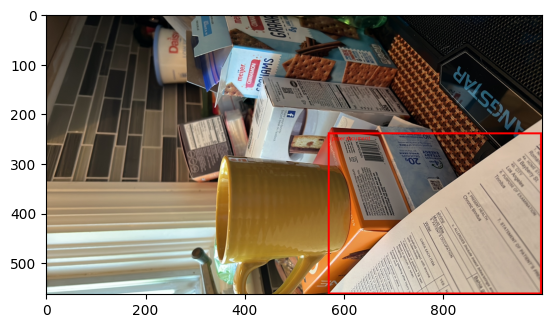

medical information / patient medical record.
medical information / patient medical record.


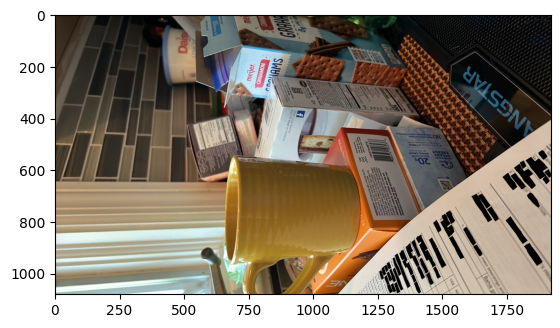

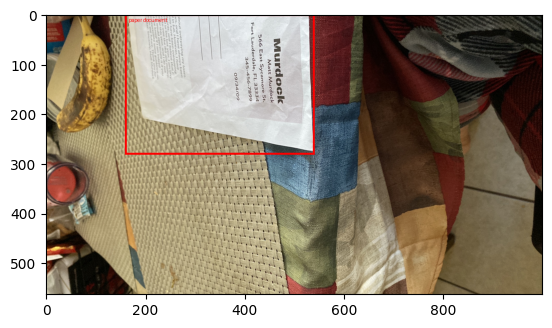

customer receipt.
customer receipt.


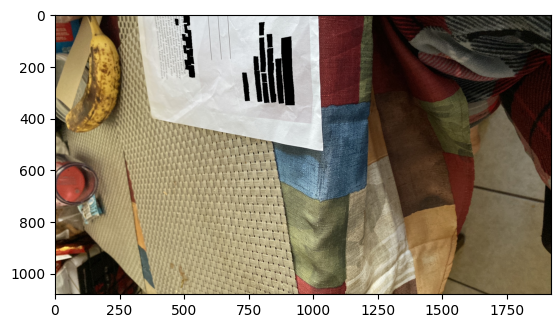

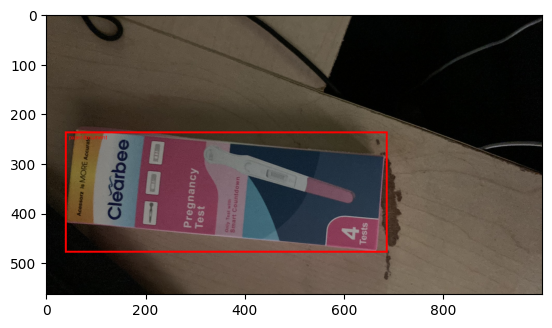

**unsure**
**unsure**


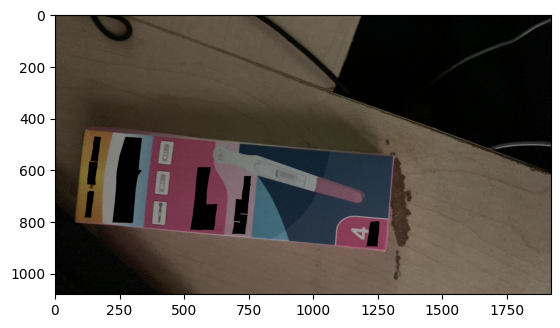

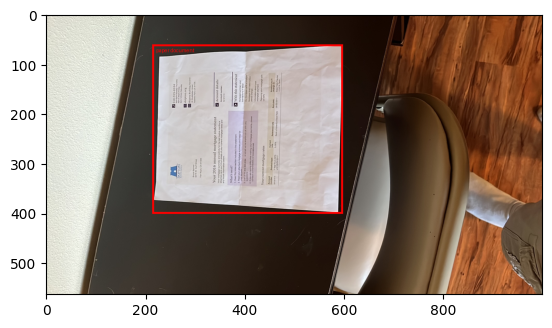

Financial statement
Financial statement


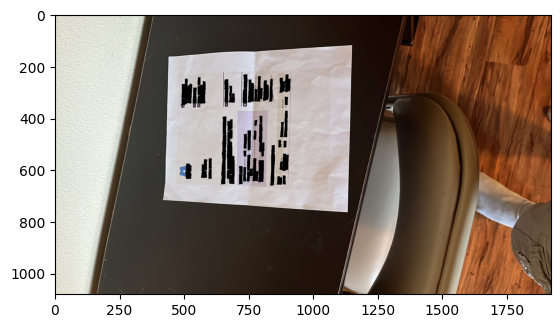

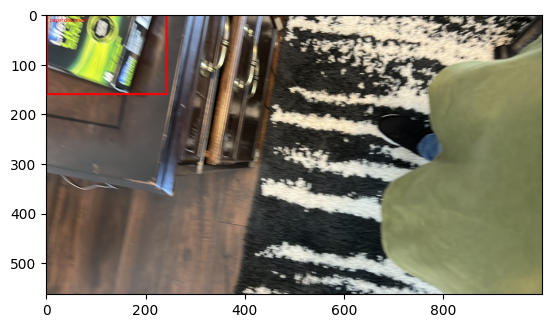

Therefore, the category is: **unsure**
unsure


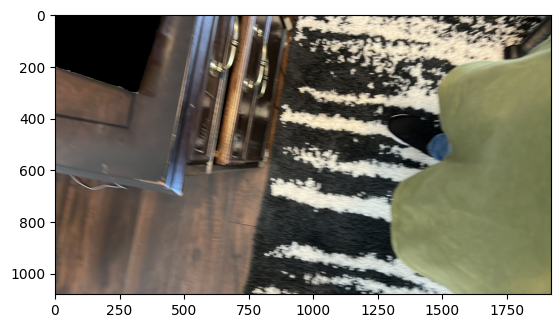

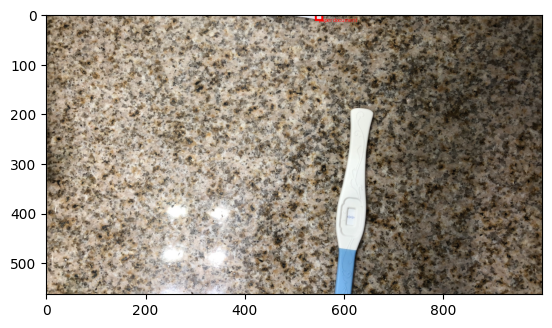

Therefore, the category is: unsure.
unsure


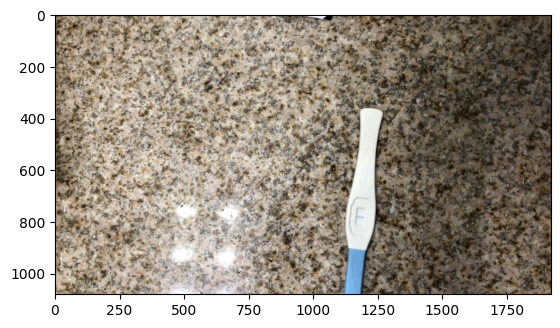

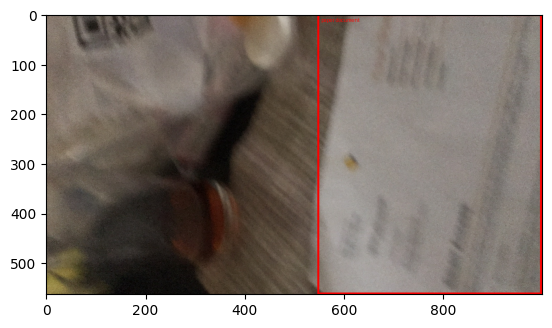

unsure.
unsure


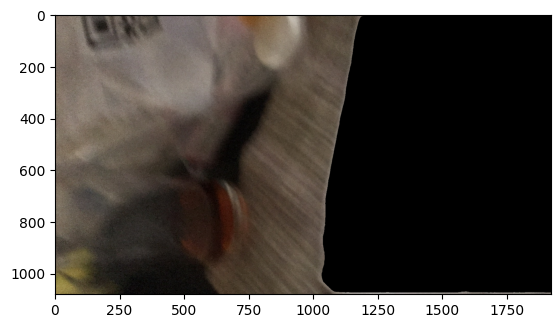

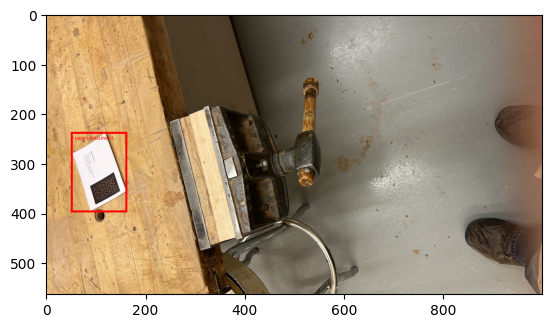

Therefore, the category is: company name.
unsure


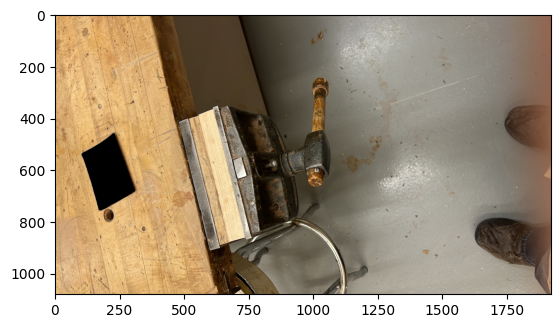

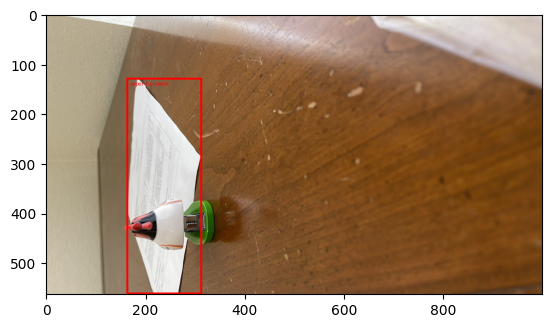

Therefore, the category is: financial statement.
unsure


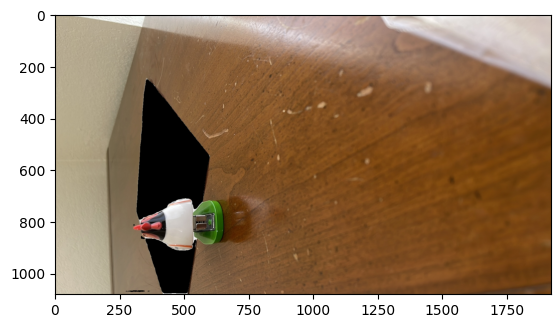

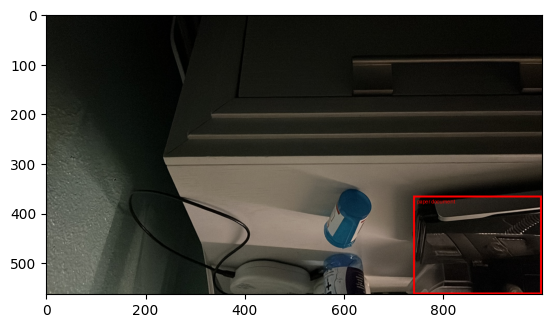

unsure.
unsure


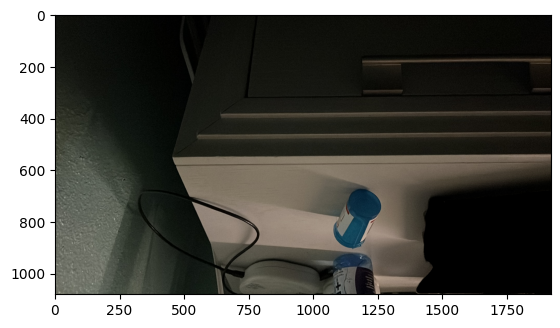

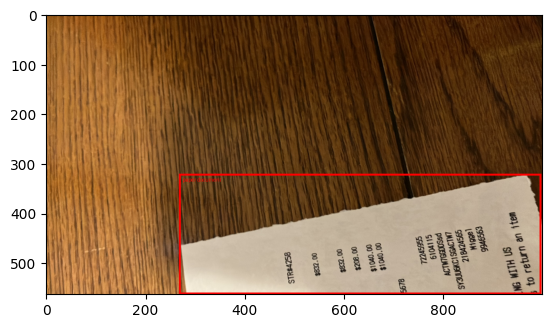

customer receipt.
customer receipt.


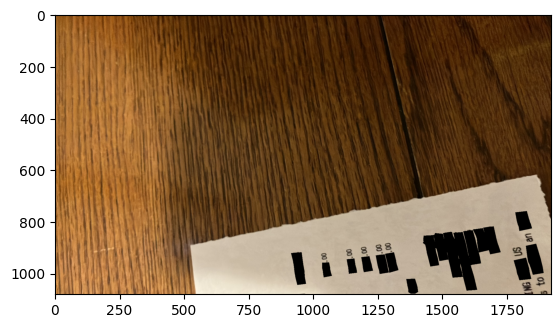

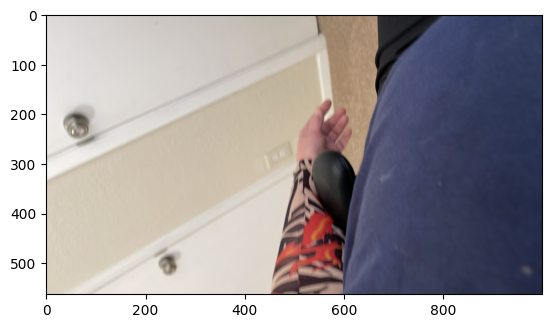

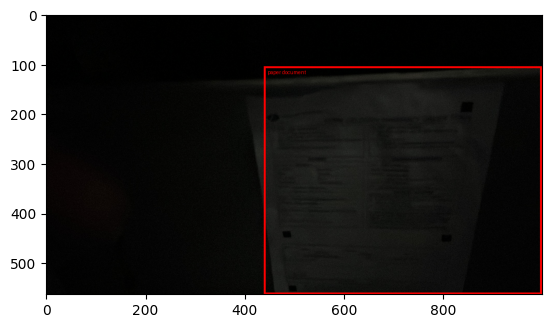

Therefore, the category is: unsure.
unsure


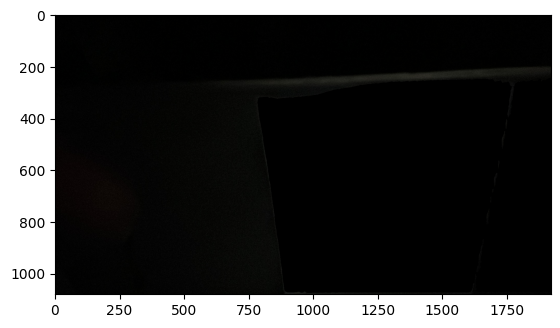

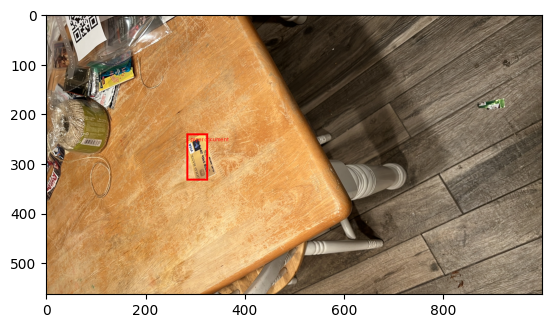

credit card
credit card


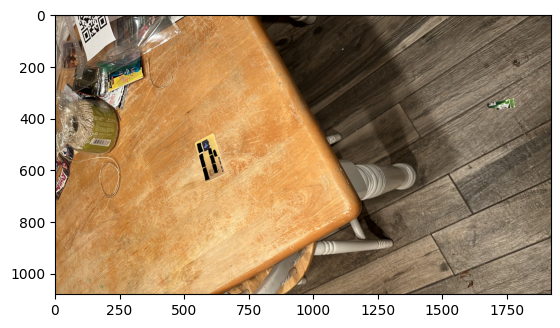

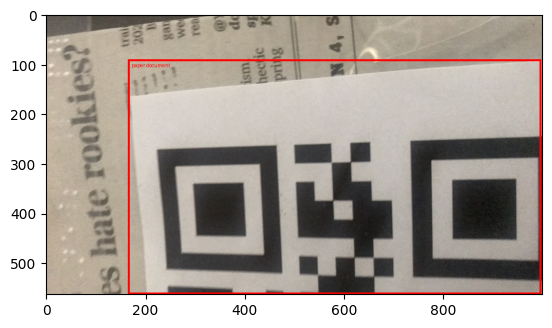

Therefore, the category is: other
unsure


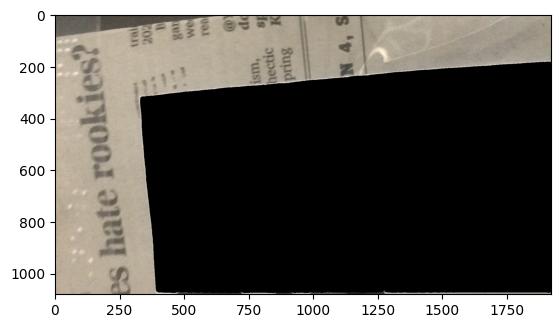

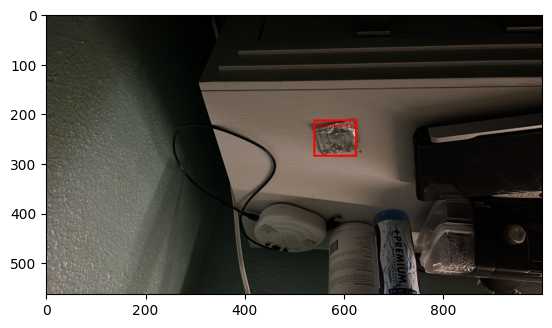

Therefore, the category is: credit card number.
unsure


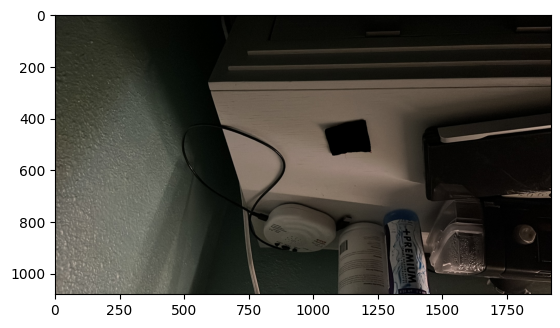

In [19]:

#folder_path = "/home/jmurrugarral/datasets/BIV-Priv_Image/support_images"

#folder_path = "/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/query_images"
folder_path = "/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images"
do_rotation = False # IF TRUE USE FIND ROTATION, AND ONLY PROCESS THE OCR IN ONE ORIENTATION OR FALSE TO PERFORM OCR IN FOUR ORIENTATION

# List all files (non-recursively)
files = glob.glob(folder_path + "/*")
print(files)
#files = [files[3]]#, files[2], files[8]]#, files[2]]#[files[1],files[2],files[3],files[4], files[5], files[6],files[7], files[8]]

predictor = SamPredictor(sam)
detection_info = {}

for ind, file in enumerate(files):

    file_name = file.split('/')[-1]
    detection_info[file_name] = {'crop': [], 'segmentation': [], 'rotation': [], 'category': [], 'fine_grained': [], 'text':[], 'label': []}
    
    image = Image.open(file)
    
    #i_crop, i_segm, i_rot, i_cat, i_fine, i_text, i_label = in_context_detection(image.copy(),)
    
    ans, img, bboxes, _ = locate_private_content(image.copy(), "Locate paper document in the image, and output in JSON format.", temperature = 1, top_p=0.8)#, show_results = False)

    plt.imshow(img)
    plt.show()


    if bboxes is None:
        bboxes = []
    for p_boxes in bboxes:

        #crop_x1,crop_y1,crop_x2,crop_y2  = int(p_boxes[0]), int(p_boxes[1]), int(p_boxes[2]), int(p_boxes[3])
        #crop_image = image.copy().crop([crop_x1,crop_y1,crop_x2,crop_y2])
        masks, y, x, segmentation = image_to_sam(image, predictor, p_boxes)    
        
        crop_x1,crop_y1,crop_x2,crop_y2  = int(np.min(x)), int(np.min(y)), int(np.max(x)), int(np.max(y))
        crop_image = image.copy().crop([crop_x1,crop_y1,crop_x2,crop_y2])

        
        category = guided_labeling(crop_image)    
        category = extract_guarantee(category)
        
        
        #plt.imshow(crop_image)
        #plt.show()
        
    
        boxes = []
        w, h = crop_image.size
        fine_grained, texts, labels, rotations = [], [], [], []
        
        if w > 28 and h > 28:

            
            mask = masks[0]
            #plt.imshow(mask)
            #plt.show()
            crop_mask = mask[crop_y1:crop_y2,crop_x1:crop_x2]
            _, boxes, d_texts, rots = rotation_fine_grained(crop_image, crop_mask, do_rotation) 
            rotations.extend(rots)
            
            if len(boxes) != 0:
                boxes[:,:,0] += crop_x1
                boxes[:,:,1] += crop_y1

        
        
        
        if len(boxes) == 0:

            image = pil_to_opencv(image)
            image[masks[0]] = [0,0,0]
            index = str(ind)

            category = 'unsure'
            
        else:

            image = pil_to_opencv(image)
            for box, text in zip(boxes,d_texts):
                
                l_box = list(box.flatten().astype(int))
                fine_grained.append(l_box)
                texts.append(text)
                labels.append('dummy_label')
                cv2.fillPoly(image, [box.astype(np.int32)], color=(0, 0, 0))

        print(category)
        detection_info[file_name]['category'].append(category)
        detection_info[file_name]['segmentation'].append(segmentation)
        detection_info[file_name]['crop'].append([crop_x1,crop_y1,crop_x2,crop_y2])
        detection_info[file_name]['fine_grained'].append(fine_grained)
        detection_info[file_name]['text'].append(texts)
        detection_info[file_name]['label'].append(labels)
        detection_info[file_name]['rotation'].append(rotations)
                
        
        
        plt.imshow(cv2.cvtColor(image,cv2.COLOR_RGB2BGR))
        plt.show()

with open("detection_info.json", "w") as f:
    json.dump(detection_info, f, cls=NumpyEncoder)